In [293]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import cv2 as cv
import glob
import time
import tensorflow as tf
from tensorflow.python.keras import layers
from keras.layers import Rescaling

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LayerNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

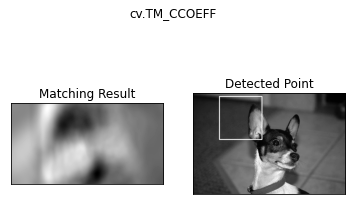

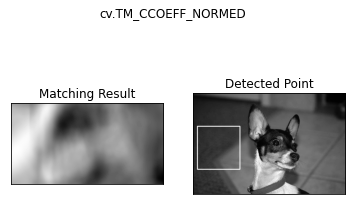

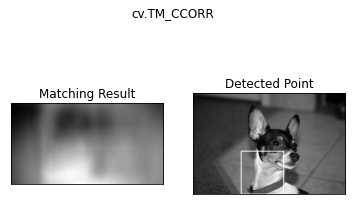

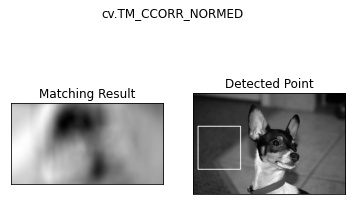

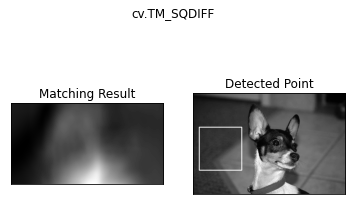

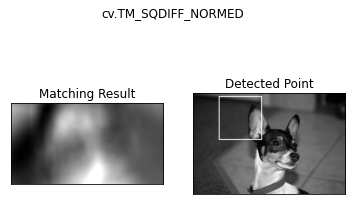

In [294]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread("C:/Users/antoi/Dropbox/PC/Desktop/Images/n02087046-toy_terrier/n02087046_6443.jpg",0)
img2 = img.copy()
template = cv.imread("C:/Users/antoi/Dropbox/PC/Desktop/Projet 6/template.jpg",0)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [295]:
dim=100

def Extract_Images_Test(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))


def Extract_Images(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        img=cv.resize(img,dsize=[100, 100])
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,0),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,-1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))

In [296]:
Folders=os.listdir('C:/Users/antoi/Dropbox/PC/Desktop/Images')
print(len(Folders))

120


In [297]:
num_classes=5

In [298]:
data=pd.DataFrame(columns=['Image','Race','RaceId'],dtype=np.float32)

In [299]:
i=0
for Folder in Folders[:num_classes]:
    tempdata=Extract_Images(Folder)
    data=pd.concat([data,pd.concat([tempdata,pd.DataFrame([i]*(tempdata.shape[0]),columns=['RaceId'])],axis=1)])
    i+=1

In [300]:
data.reset_index(inplace=True)

In [301]:
print(data.shape)

(3808, 4)


In [302]:
class_names=pd.unique(data['Race'])

In [303]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))
data_original=data.copy()

In [304]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [305]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    dst = cv.cornerHarris(gray,2,3,0.04)
    img[dst>0.005*dst.max()]=[255,0,0]
    if k%10000==0:
        print(k)

data=pd.concat([data,data_original],axis=0)
data_original=data.copy()

0


In [306]:
data.reset_index(inplace=True)

print(data.shape)

(7616, 6)


In [307]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [308]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))


In [309]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(img, None)
    img=cv.drawKeypoints(gray,kp,img)
    if k%10000==0:
        print(k)

0


In [310]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [311]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [312]:
data=pd.concat([data,data_original],axis=0)
data=data.drop(['level_0','index'],axis=1)
data.reset_index(inplace=True)
print(data.shape)

(15232, 5)


## Pre processing of the data

In [313]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LayerNormalization
from tensorflow.keras import losses, optimizers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [314]:
train_image,test_image,train_label, test_label = train_test_split(data.loc[:,['Image','Grayscale']],data.loc[:,['Race','RaceId']],stratify=data['RaceId'],test_size=0.1)

<AxesSubplot:xlabel='class', ylabel='prop'>

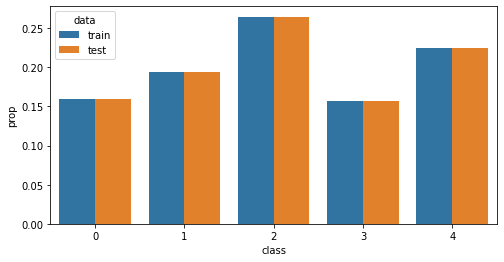

In [315]:
y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_label['RaceId']) / train_label.shape[0],
                         np.bincount(test_label['RaceId']) / test_label.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

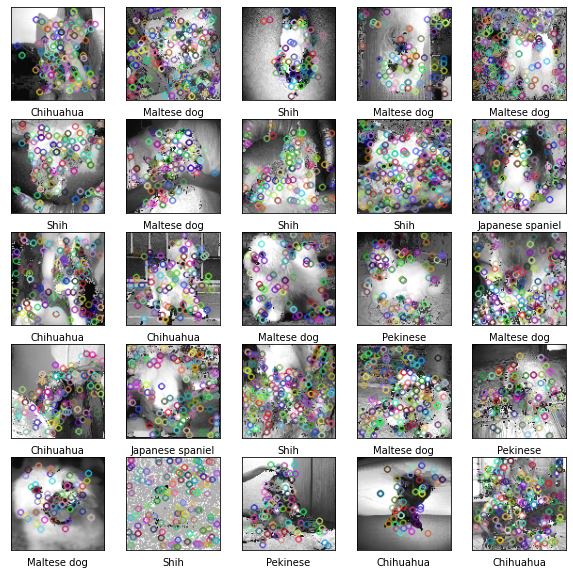

In [316]:
plt.figure(figsize=(10,10))
k=0
for i in train_image.index[:25]:
    plt.subplot(5,5,k+1)
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image['Image'][i])
    plt.xlabel(train_label['Race'][i])
plt.show()

We normalize the data:

In [317]:
train_images = train_image['Image']
test_images = test_image['Image']

train_labels=train_label['RaceId']
test_labels=test_label['RaceId']

input_shape = (dim,dim,3)

The scale of grey is now from 0 to 1.

In [318]:
train_labels.shape

(13708,)

In [319]:
test_labels.shape

(1524,)

###**Creation of a validation set**

We further split the train set into a train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

The actual training set will be divided into two groups:
* the training set
* the validation set

In [320]:

train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2020)

In [321]:
train_id=train_images.index
valid_id=valid_images.index
test_id=test_images.index

In [322]:
partition = {'train' : [str(i) for i in train_id], 'validation' : [str(i) for i in valid_id]}

labels={}
for i in train_id:
    labels[str(i)]=train_labels[i]
for i in valid_id:
    labels[str(i)]=valid_labels[i]


### We define a class used not to overflow our GPU.

In [323]:
batch_size=32
epochs=40

In [324]:
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=batch_size, dim=input_shape, n_classes=num_classes, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = data['Image'][int(ID)]

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [325]:
train_images=np.asarray([i.astype(np.float32) for i in train_images])

valid_images=np.asarray([i.astype(np.float32) for i in valid_images])

test_images=np.asarray([i.astype(np.float32) for i in test_images])

In [326]:
test_labels = to_categorical(test_labels, num_classes)
test_labels=np.asarray([i.astype(np.float32) for i in test_labels])

In [327]:
#Generators

training_generator = DataGenerator(partition['train'], labels)
validation_generator = DataGenerator(partition['validation'], labels)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

### **4th version of the CNN: Preventing overfitting and adding layers**

In [331]:
time0=time.time()
model_cnn4 = Sequential()
model_cnn4.add(Rescaling(1./255, input_shape=input_shape))
model_cnn4.add(Conv2D(16, kernel_size=10, activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn4.add(MaxPooling2D(pool_size=3, name='max_pool_1'))
model_cnn4.add(Conv2D(32, kernel_size=8, activation='relu', name='conv2d_2'))
model_cnn4.add(MaxPooling2D(pool_size=2, name='max_pool_2'))
model_cnn4.add(Dropout(0.25, name='dropout_1'))
model_cnn4.add(Conv2D(32, kernel_size=6, activation='relu', name='conv2d_3'))
model_cnn4.add(MaxPooling2D(pool_size=2, name='max_pool_3'))
model_cnn4.add(Dropout(0.25, name='dropout_2'))
model_cnn4.add(Flatten(name='flatten'))
model_cnn4.add(Dense(50, activation='relu', name='dense'))
model_cnn4.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [332]:
# Run the train
history_cnn4 = model_cnn4.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/40
342/342 [==============================] - 3s 9ms/step - loss: 1.5933 - accuracy: 0.2609 - val_loss: 1.5746 - val_accuracy: 0.2721

In [333]:
score_cnn4 = model_cnn4.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn4[0])
print('Test accuracy:', score_cnn4[1])
time1=time.time()-time0

Test loss: 0.0965212807059288
Test accuracy: 0.9822834730148315


*Remarks:*

We run the same models with different "batch_size" (10, 64, 128) and noticed that:
* for the firsts CNNs, a small batch_size led to better accuracy levels.
* However, for the last ones (which have been otpimized from the previous ones), changing the batch size didn't have a significant effect on the accuracy level.


### **5th version of the CNN: Fine-tuning and trials**

In [334]:

time0=time.time()
model_cnn5 = Sequential()
model_cnn5.add(Rescaling(1./255, input_shape=input_shape))
model_cnn5.add(LayerNormalization())
model_cnn5.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_cnn5.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))

model_cnn5.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))

model_cnn5.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))



model_cnn5.add(Flatten())
model_cnn5.add(Dense(num_classes*10, activation='relu'))
model_cnn5.add(Dropout(0.1))
model_cnn5.add(Dense(num_classes, activation='softmax'))

model_cnn5.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy'],
)


model_cnn5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 layer_normalization_3 (Laye  (None, 100, 100, 3)      6         
 rNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 64)      

In [335]:
# Run the train
history_cnn5 = model_cnn5.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/40
342/342 [==============================] - 84s 238ms/step - loss: 1.5774 - accuracy: 0.2779 - val_loss: 1.5513 - val_accuracy: 0.2926

In [336]:
score_cnn5 = model_cnn5.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn5[0])
print('Test accuracy:', score_cnn5[1])
time1=time.time()-time0


Test loss: 0.2002056986093521
Test accuracy: 0.9665354490280151


In [337]:
model_cnn5.save('saved_model/model5')

INFO:tensorflow:Assets written to: saved_model/model5\assets


INFO:tensorflow:Assets written to: saved_model/model5\assets


# Re-training du VGG16

In [339]:
from keras.applications import VGG16

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False ## Not trainable weights


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(num_classes*10, activation='relu')
dense_layer_2 = layers.Dense(num_classes*5, activation='relu')
dropout_layer = layers.Dropout(0.1)
prediction_layer = layers.Dense(num_classes, activation='softmax')


model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_model=model.fit(training_generator,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=validation_generator,
                            callbacks=[es])

Epoch 1/40
342/342 [==============================] - 15s 38ms/step - loss: 1.7947 - accuracy: 0.2821 - val_loss: 1.4948 - val_accuracy: 0.3063

In [340]:
score_model = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_model[0])
print('Test accuracy:', score_model[1])

Test loss: 0.490464985370636
Test accuracy: 0.8280839920043945


# Comparaison entre notre modèle "Fait-main" et VGG16



### Comparaison of accuracy and loss

In [341]:
# summarize history for accuracy

def history_accuracy(history_model):
  history = history_model
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
# summarize history for loss

def history_loss(history_model):
  history = history_model
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()



4TH CNN MODEL: 


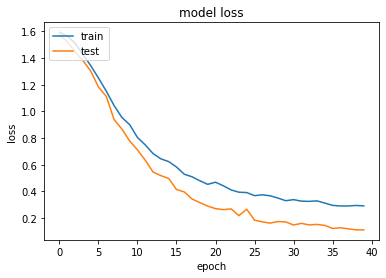

5th CNN MODEL:


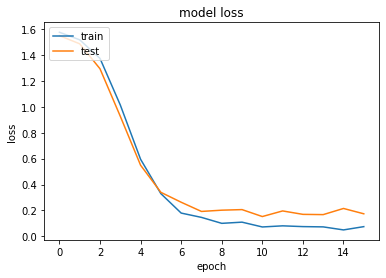

VGG16 MODEL: 


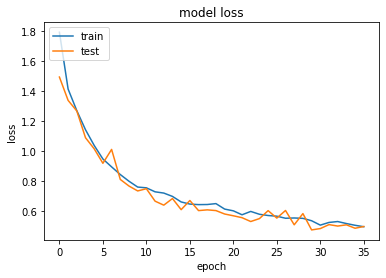

In [343]:
#Loss

print("4TH CNN MODEL: ")
history_loss(history_cnn4)
print("5th CNN MODEL:")
history_loss(history_cnn5)
print("VGG16 MODEL: ")
history_loss(history_model)

The lower the loss, the better a model. The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets. In the case of neural networks, the loss is usually negative log-likelihood and residual sum of squares for classification and regression respectively.

By increasing the number of epochs, the loss would have probably continue to decrease for the 1st nd 2nd CNN. However, it stays at 1st a higher lever for those models than the last one.
We note that the 3rd CNN's loss function of the test set diverges from the loss function of the train set. One would expect the reduction of loss after each, or several, iterations, which is clearly not the case for this model's test set.

The first and second models achieve lower accuracy level. However, the train and test accuracy levels are close enough to conclude that there is no overfitting.
Overfitting is clearly observed in the 3rd model, and largely reduced in the 4th one.

4TH CNN MODEL: 


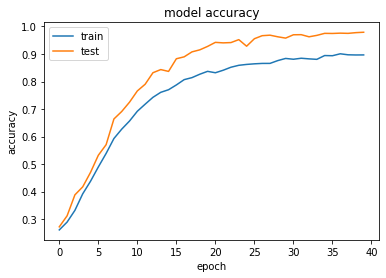

5TH CNN MODEL: 


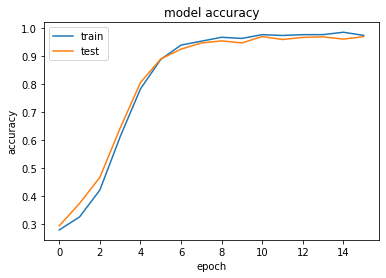

VGG16 MODEL: 


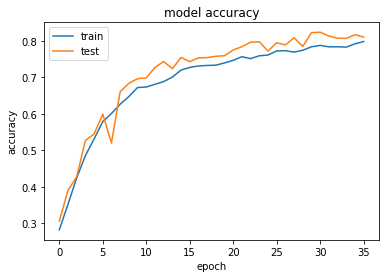

In [344]:
# Accuracy
print("4TH CNN MODEL: ")
history_accuracy(history_cnn4)
print("5TH CNN MODEL: ")
history_accuracy(history_cnn5)
print("VGG16 MODEL: ")
history_accuracy(history_model)


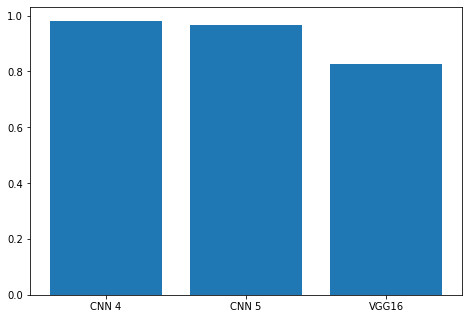

In [345]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
CNN = ['CNN 4','CNN 5', 'VGG16']
Test_Accuracy = [score_cnn4[1],score_cnn5[1],score_model[1]]
ax.bar(CNN,Test_Accuracy)
plt.show()

### II. B. Which dogs are the harder to classify ?

In [346]:
def plot_image(i, predictions_array, true_label, img):
    true_label_temp, img_temp = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img_temp)

    predicted_label = np.argmax(predictions_array)
    true_label2=np.argmax(true_label_temp)
    if predicted_label == np.argmax(true_label_temp):
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label2]),
                                color=color)



def plot_value_array(i, predictions_array, true_label):
    true_label_temp = true_label[i]
    plt.grid(False)
    plt.xticks(range(num_classes))
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label2=np.argmax(true_label_temp)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label2].set_color('blue')

In [347]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_prediction_images(prediction):
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range (num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, prediction[i], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, prediction[i], test_labels)
    plt.tight_layout()
    plt.show()



In [348]:
import tensorflow


### 4th CNN predictions

48/48 [==============================] - 0s 9ms/step


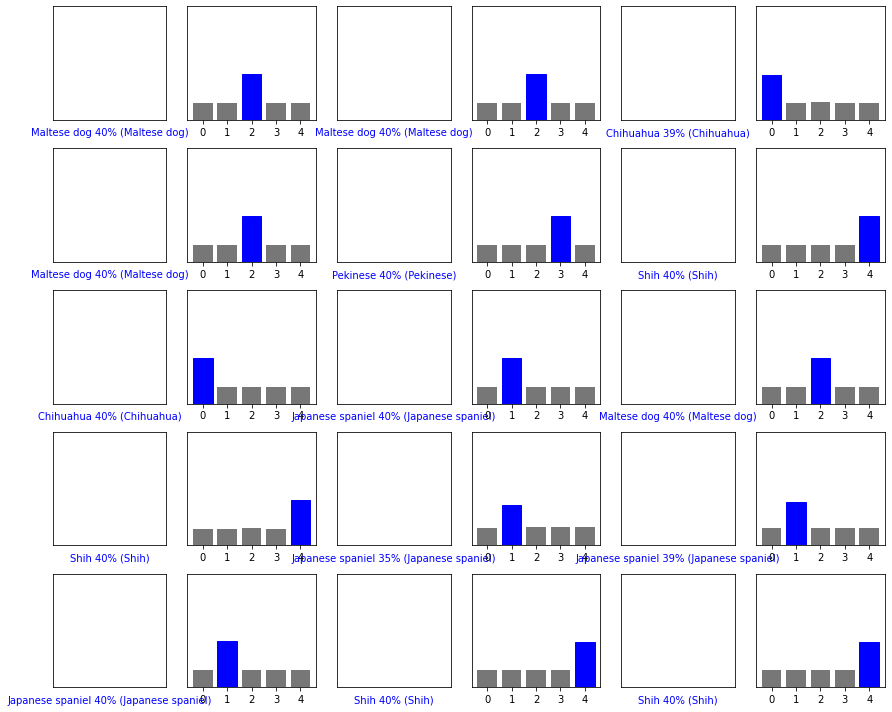

In [349]:
probability_model4 = tensorflow.keras.Sequential([model_cnn4,
                                         tensorflow.keras.layers.Softmax()])
predictions4 = probability_model4.predict(test_images)
plot_prediction_images(predictions4)

### 5th CNN predictions

48/48 [==============================] - 1s 22ms/step


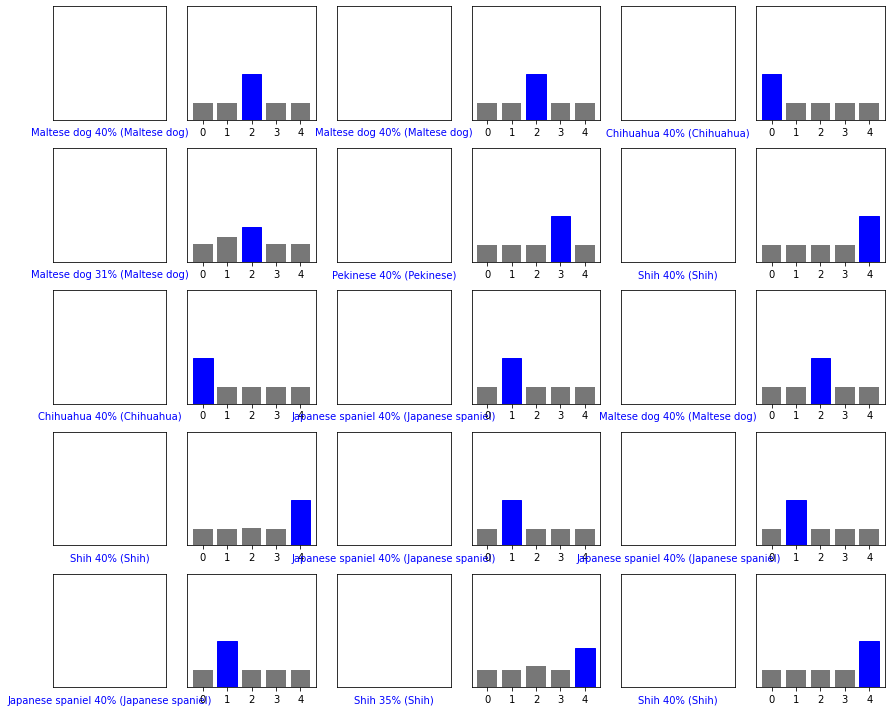

In [350]:
probability_model5 = tensorflow.keras.Sequential([model_cnn5,
                                         tensorflow.keras.layers.Softmax()])
predictions5 = probability_model5.predict(test_images)
plot_prediction_images(predictions5)

### VGG16 predictions

48/48 [==============================] - 2s 31ms/step

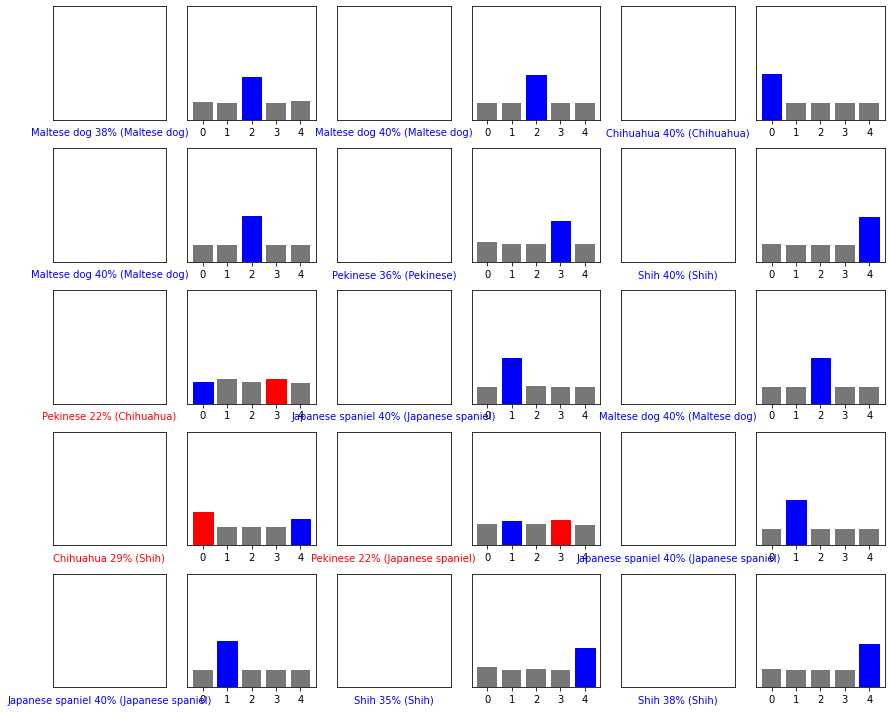

In [351]:
probability_model = tensorflow.keras.Sequential([model,
                                         tensorflow.keras.layers.Softmax()])
predictions_vgg = probability_model.predict(test_images)
plot_prediction_images(predictions_vgg)

In [352]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [353]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

48/48 [==============================] - 0s 3ms/step


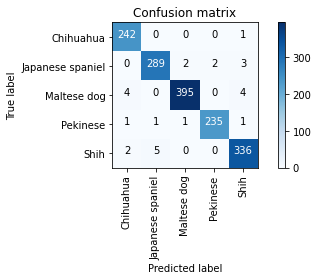

In [354]:
# Predict the values from the validation dataset
Y_pred = model_cnn4.predict(test_images)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)


48/48 [==============================] - 1s 20ms/step


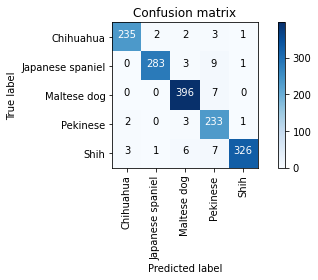

In [355]:
# Predict the values from the validation dataset
Y_pred = model_cnn5.predict(test_images)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)